In [43]:
import nltk
import spacy
import string
import bz2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm


import json
import os
import pickle
from typing import *
from bs4 import BeautifulSoup
from collections import Counter
from itertools import islice
import xml.etree.ElementTree as ET
from nltk.tokenize import sent_tokenize
from langdetect import detect_langs
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras

from transformers import AutoTokenizer, AutoModel
import torch
import pymorphy2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from xgboost import XGBClassifier


In [ ]:
!python3 -m spacy download uk_core_news_lg

In [2]:
nltk.download('punkt')
nlp = spacy.load("uk_core_news_lg")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/taraskozak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Additions

In [116]:
def parse_vector(vector_str):
    try:
        vector_str = vector_str.replace("\n", " ")
        vector_str = vector_str.replace("  ", " ")
        vector_str = vector_str.strip("[]")
        vector_list = np.array([float(num) for num in vector_str.split()], dtype=np.float32)
        return vector_list
    except Exception as e:
        print(f"Error parsing vector: {vector_str} -> {e}")
        return np.zeros(300, dtype=np.float32)

In [69]:
# Load GloVe embeddings once
def load_glove_embeddings(glove_path):
    word_vectors = {}
    with bz2.open(glove_path, "rt", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]  # The word itself
            vector = np.array(parts[1:], dtype=np.float32)  # The word vector
            word_vectors[word] = vector
    return word_vectors

# Load GloVe vectors
glove_path = "./news.lowercased.lemmatized.glove.300d.bz2"
word_vectors = load_glove_embeddings(glove_path)

def get_text_vector(text, word_vectors):
    text = text.lower()
    doc = nlp(text)
    vectors = [word_vectors[token.text] for token in doc if token.text in word_vectors]

    if vectors:
        return np.mean(vectors, axis=0)  # Average word vectors
    else:
        return np.zeros(300)



In [59]:
def count_named_entities(text):
    doc = nlp(text)
    location_count = sum(1 for ent in doc.ents if ent.label_ == "LOC")  # Count locations
    organization_count = sum(1 for ent in doc.ents if ent.label_ == "ORG")  # Count organizations
    return location_count, organization_count

In [56]:
def avg_noun_verb_ratio(text):
    doc = nlp(text)
    ratios = []
    
    for sent in doc.sents:  # Process each sentence separately
        nouns = sum(1 for token in sent if token.pos_ == "NOUN")
        verbs = sum(1 for token in sent if token.pos_ == "VERB")
        if verbs > 0:
            ratios.append(nouns / verbs)  # Compute noun/verb ratio
        else:
            ratios.append(0)  # Avoid division by zero

    return sum(ratios) / len(ratios) if ratios else 0  # Compute the average

In [31]:
def calculate_subj(text):
    
    subj_dict_synt = {}

    tree = ET.parse("./xmls/translated_output.xml")
    root = tree.getroot()

    # Extract words and polarity
    for word in root.findall("word"):
        word_form = word.get("form")
        polarity = float(word.get("subjectivity", 0))  # Default polarity = 0 if not present
        subj_dict_synt[word_form] = polarity
    
    if not isinstance(text, str):
        return 0.0  # Return neutral score for missing values
    words = text.split()  # Tokenize text
    score = sum(subj_dict_synt.get(word, 0) for word in words)  # Sum word polarities
    return score

In [30]:
def calculate_sentiment(text):
    
    sentiment_dict_synt = {}

    tree = ET.parse("./xmls/translated_output.xml")
    root = tree.getroot()

    # Extract words and polarity
    for word in root.findall("word"):
        word_form = word.get("form")
        polarity = float(word.get("polarity", 0))  # Default polarity = 0 if not present
        sentiment_dict_synt[word_form] = polarity
    
    if not isinstance(text, str):
        return 0.0  # Return neutral score for missing values
    words = text.split()  # Tokenize text
    score = sum(sentiment_dict_synt.get(word, 0) for word in words)  # Sum word polarities
    return score

In [3]:
def extract_ner_and_word_count(texts):
    """
    Extract NER count and total word count for each text.
    Returns a list of (ner_count, word_count) tuples for each document.
    """
    ner_to_word_ratio = []
    entity_types = {}

    for doc in nlp.pipe(texts, disable=["tagger", "parser"]):  # Speed up processing
        ner_count = len(doc.ents)
        word_count = len([token.text for token in doc if not token.is_stop and not token.is_punct])
        
        for ent in doc.ents:
            entity_types[ent.label_] = entity_types.get(ent.label_, 0) + 1
        
        ner_to_word_ratio.append((ner_count, word_count))

    return ner_to_word_ratio, entity_types


In [4]:
def extract_ner(texts):
    """
    Extract named entities and their types from a list of texts.
    Returns a dictionary with counts of entities and entity types.
    """
    total_entities = 0
    entity_counts = {}

    for doc in nlp.pipe(texts, disable=["tagger", "parser"]):  # Speed up processing
        for ent in doc.ents:
            total_entities += 1
            entity_counts[ent.label_] = entity_counts.get(ent.label_, 0) + 1

    return total_entities, entity_counts

In [5]:
def get_pos_counts(texts):
    pos_counter = Counter()
    total_tokens = 0
    for doc in nlp.pipe(texts, disable=["parser", "ner"]):
        tokens = [token.pos_ for token in doc]
        pos_counter.update(tokens)
        total_tokens += len(tokens)
    return {pos: count / total_tokens for pos, count in pos_counter.items()}

In [6]:
def lemmatize_text(text):
    if not isinstance(text, str):  # Handle NaN or non-string cases
        return ""
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [7]:
def count_punctuation(text):
    if pd.isna(text):
        return Counter()
    return Counter(c for c in text if c in string.punctuation)

In [8]:
def normalize_counts(counter):
    total = sum(counter.values())
    return {k: (v / total) * 100 for k, v in counter.items()} if total > 0 else {}

In [9]:
def avg_sentence_length(text):
    sentences = nltk.sent_tokenize(text)  # Tokenize into sentences
    if not sentences:
        return 0  # Handle empty texts
    sentence_lengths = [len(sentence) for sentence in sentences]  # Compute sentence lengths
    return sum(sentence_lengths) / len(sentences)  # Average sentence length

In [10]:
def truncate_text(text, max_length=350):
    sentences = sent_tokenize(text)  # Split text into sentences
    truncated_text = []
    current_length = 0

    for sentence in sentences:
        if current_length + len(sentence) <= max_length:  # Ensure limit is not exceeded
            truncated_text.append(sentence)
            current_length += len(sentence) + 1  # +1 for space or punctuation

        else:
            break  # Stop adding sentences once max_length is exceeded

    return " ".join(truncated_text)

In [11]:
def clean_html(text):
    return BeautifulSoup(text, "html.parser").get_text()

In [12]:
def convert_json_list_to_pandas(json_list):
    compiled_doc = {}
    for json_doc in json_list:
        for key, val in json_doc.items():
            compiled_doc[key] = compiled_doc.get(key, []) + [val]
    data = pd.DataFrame()
    for key, val in compiled_doc.items():
        data[key] = val
    return data

def load_from_folder(folder: str, languages: List[str] = ["ar", 'de', "en", "es", "fr", "it", "ua", "ru", "zh"]):
    docs = []
    if folder[-1] != '/':
        folder = folder + '/'
    if type(languages) == str:
        languages = [languages]
    dataset_files = os.listdir(folder)
    for file in dataset_files:
        if file[-4:] == "json":
            with open(folder+file, 'r') as f:
                lines = f.readlines()[0]
            doc_json = json.loads(lines)
            if doc_json["language"] in languages:
                docs.append(doc_json)
    return docs

def load_from_folder_tribunal_ukraine(folder: str, languages: List[str] = ['de', "en", "es", "fr", "ru"]):
    docs = []
    if folder[-1] != '/':
        folder = folder + '/'
    if type(languages) == str:
        languages = [languages]
    language_list_tribunal_ukraine = ["lang=" + lang for lang in languages]
    if "de" in languages:
        language_list_tribunal_ukraine.append("lang=_")
    dataset_files = os.listdir(folder)
    for file in dataset_files:
        if file[-4:] == "json":
            for lang in language_list_tribunal_ukraine:
                if lang in file:
                    with open(folder+file, 'r') as f:
                        lines = f.readlines()[0]
                    doc_json = json.loads(lines)
                    docs.append(doc_json)
    return docs

def load_rrn(languages: List[str] = ["ar", 'de', "en", "es", "fr", "it", "ua", "ru", "zh"]):
    if type(languages) == str:
        languages = [languages]
    docs = load_from_folder("ppn_data/2023/09/13/rrn.media/", languages=languages)
    return convert_json_list_to_pandas(docs)

def load_tribunalukraine(languages: List[str] = ['de', "en", "es", "fr", "ru"]):
    # Language identification is broken for this dataset
    if type(languages) == str:
        languages = [languages]
    docs = load_from_folder_tribunal_ukraine("ppn_data/2023/11/09/tribunalukraine.info/", languages=languages)
    return convert_json_list_to_pandas(docs)

def load_waronfakes(languages: List[str] = ["ar", 'de', "en", "es", "fr", "zh"]):
    if type(languages) == str:
        languages = [languages]
    docs = load_from_folder("ppn_data/2023/11/09/waronfakes.com/", languages=languages)
    return convert_json_list_to_pandas(docs)

def load_lavirgule():
    # Articles are only in French but the language annotator didn't work correctly
    languages = ["ar", 'de', "en", "es", "fr", "it", "ua", "ru", "zh"]
    if type(languages) == str:
        languages = [languages]
    docs = load_from_folder("ppn_data/2023/11/09/lavirgule.news/", languages=languages)
    return convert_json_list_to_pandas(docs)

def load_notrepays():
    # Articles are only in French but the language annotator didn't work correctly
    languages = ["ar", 'de', "en", "es", "fr", "it", "ua", "ru", "zh"]
    if type(languages) == str:
        languages = [languages]
    docs = load_from_folder("ppn_data/2023/11/09/notrepays.today/", languages=languages)
    return convert_json_list_to_pandas(docs)

def load_regular_fr():
    return pickle.load(open("regular_data/regular_ukraine_FR.pkl", "rb"))

def load_regular_en():
    return pickle.load(open("regular_data/regular_ukraine_EN.pkl", "rb"))



def load_ppn(languages: List[str] = ["ar", 'de', "en", "es", "fr", "it", "ua", "ru", "zh"]):
    if type(languages) == str:
        languages = [languages]
    rrn_docs = load_from_folder("ppn_data/2023/09/13/rrn.media/", languages=languages)
    tribunalukraine_docs = load_from_folder_tribunal_ukraine("ppn_data/2023/11/09/tribunalukraine.info/", languages=languages)
    waron_fakes_doc = load_from_folder("ppn_data/2023/11/09/waronfakes.com/", languages=languages)
    docs = rrn_docs + tribunalukraine_docs + waron_fakes_doc
    if "fr" in languages:
        lavirgule_docs = load_from_folder("ppn_data/2023/11/09/lavirgule.news/", languages=["ar", 'de', "en", "es", "fr", "it", "ua", "ru", "zh"])
        notrepays_docs = load_from_folder("ppn_data/2023/11/09/notrepays.today/", languages=["ar", 'de', "en", "es", "fr", "it", "ua", "ru", "zh"])
        docs = docs + lavirgule_docs + notrepays_docs
    return convert_json_list_to_pandas(docs)

# First dataset (OSINT)

In [3]:
df = pd.read_excel('../../data/full_data.xlsx')

In [5]:
df.head()

,Sentence,Заперечення,Виправдовування,Заклик,Розпалювання ворожнечі та ненависті,Приниження національної честі та гідності
0,"День сегодня очень важный, потому что, как мы ...",0,0,0,0,0
1,Решение очень важное.,0,0,0,0,0
2,Почему?,0,0,0,0,0
3,Потому что Государственная Дума ратифицировала...,0,0,0,0,0
4,А дальше было решение Совета Федерации.,0,0,0,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17960 entries, 0 to 17959
Data columns (total 6 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Sentence                                   17959 non-null  object
 1   Заперечення                                17960 non-null  int64 
 2   Виправдовування                            17960 non-null  int64 
 3   Заклик                                     17960 non-null  int64 
 4   Розпалювання ворожнечі та ненависті        17960 non-null  int64 
 5   Приниження національної честі та гідності  17960 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 842.0+ KB


In [8]:
cols = df.select_dtypes(include=['int64']).columns

In [9]:
df['Має наративи'] = df[cols].eq(1).any(axis=1).astype(int)

In [10]:
df['Має наративи'].sum()

81

In [11]:
print(f'All rows: {df.shape[0]}')
df[cols].sum()

All rows: 17960


Заперечення                                  12
Виправдовування                              55
Заклик                                        7
Розпалювання ворожнечі та ненависті           1
Приниження національної честі та гідності     6
dtype: int64

In [12]:
df[df['Має наративи'] == 0].head(100)

,Sentence,Заперечення,Виправдовування,Заклик,Розпалювання ворожнечі та ненависті,Приниження національної честі та гідності,Має наративи
0,"День сегодня очень важный, потому что, как мы ...",0,0,0,0,0,0
1,Решение очень важное.,0,0,0,0,0,0
2,Почему?,0,0,0,0,0,0
3,Потому что Государственная Дума ратифицировала...,0,0,0,0,0,0
4,А дальше было решение Совета Федерации.,0,0,0,0,0,0
...,...,...,...,...,...,...,...
96,"Там не хватает только одного, не хватает тольк...",0,0,0,0,0,0
97,Но это вопрос техники.,0,0,0,0,0,0
98,"Для Украины это не нерешаемая проблема, она ре...",0,0,0,0,0,0
99,"Что касается средств доставки, то я уже говори...",0,0,0,0,0,0


# Second dataset (PPN)

In [5]:
df_ppn = load_ppn()
df_ruwa = pd.read_csv('RUWA_new_16.01.2025.csv')

In [6]:
df_ppn

,authors,date_download,date_modify,date_publish,description,filename,image_url,language,title,title_page,title_rss,source_domain,maintext,url
0,"[Reliable Recent News, Source]",2023-09-13 12:57:40,2023-09-13 12:57:40,2023-03-24 10:51:00,بسبب الاحتجاجات ، يواجه الفرنسيون نقصًا في الو...,ar__1694609860.html,https://rrn.media/wp-content/uploads/2023/03/r...,ar,فيديو: عواقب وخيمة,فيديو: عواقب وخيمة - الأخبار,NULL,rrn.media,بسبب الاحتجاجات ، يواجه الفرنسيون نقصًا في الو...,https://rrn.media/ar/fedew-awaqb-wkhemtt/
1,"[Reliable Recent News, Source]",2023-09-13 13:54:55,2023-09-13 13:54:55,2023-07-31 12:31:00,Бывший президент становится серьезной угрозой ...,ru__1694613295.html,https://rrn.media/wp-content/uploads/2023/07/1...,ru,Все боятся Трампа,Все боятся Трампа - Новости,NULL,rrn.media,Бывший президент становится серьезной угрозой ...,https://rrn.media/ru/vse-boyatsya-trampa/
2,"[Reliable Recent News, Source]",2023-09-13 14:59:49,2023-09-13 14:59:49,2022-06-10 09:00:00,العقوبات المناهضة لروسيا تقوض رفاهية الاتحاد ا...,ar__1694617189.html,https://rrn.media/wp-content/uploads/2022/06/3...,ar,الحظر المفروض على الغاز الروسي سيدمر تماما اقت...,الحظر المفروض على الغاز الروسي سيدمر تماما اقت...,NULL,rrn.media,العقوبات المناهضة لروسيا تقوض رفاهية الاتحاد ا...,https://rrn.media/ar/16761/
3,"[Reliable Recent News, Source]",2023-09-13 12:36:10,2023-09-13 12:36:10,2023-05-30 10:29:09,Erdogan s’attaque au problème de l’inflation d...,fr__1694608570.html,https://rrn.media/wp-content/uploads/2023/05/i...,fr,La Turquie quitte le dollar pour les BRICS,La Turquie quitte le dollar pour les BRICS - A...,NULL,rrn.media,Erdogan s’attaque au problème de l’inflation d...,https://rrn.media/fr/la-turquie-quitte-le-doll...
4,"[Reliable Recent News, Source]",2023-09-13 14:13:46,2023-09-13 14:13:46,2022-07-12 00:00:00,Top news and events of the week in the RRN’s d...,__1694614426.html,https://rrn.media/wp-content/uploads/2022/07/1...,en,Germany Right Now,Germany Right Now - Useful Links,NULL,rrn.media,US Air Force Secretary Frank Kendall states th...,https://rrn.media/germany-right-now/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18724,[],2023-11-09 08:14:15,2023-11-09 08:14:15,2023-09-27 23:55:00,L'ambassadeur de France au Niger quitte le pay...,_lambassadeur-de-france-au-niger-quitte-le-pay...,https://notrepays.today/wp-content/uploads/202...,en,L'ambassadeur de France au Niger quitte le pay...,L'ambassadeur de France au Niger quitte le pay...,NULL,notrepays.today,L’ambassadeur de France au Niger a atterri à P...,https://notrepays.today/lambassadeur-de-france...
18725,[],2023-11-09 08:11:51,2023-11-09 08:11:51,2023-07-19 02:25:00,100 jours Archives - Notrepays,tag_100-jours_1699517511.html,https://notrepays.today/favicon.png,en,100 jours Archives,100 jours Archives - Notrepays,NULL,notrepays.today,None,https://notrepays.today/tag/100-jours
18726,[],2023-11-09 08:04:04,2023-11-09 08:04:04,2023-06-27 04:59:35,Un député LFI condamné a faire un stage de cit...,_un-depute-lfi-condamne-a-faire-un-stage-de-ci...,https://notrepays.today/wp-content/uploads/202...,en,Un député LFI condamné a faire un stage de cit...,Un député LFI condamné a faire un stage de cit...,NULL,notrepays.today,Si la réforme des retraites a bel et bien abou...,https://notrepays.today/un-depute-lfi-condamne...
18727,[],2023-11-09 08:09:18,2023-11-09 08:09:18,2023-04-04 15:43:24,La gauche s’insurge sans jamais débattre - Not...,_la-gauche-sinsurge-sans-jamais-debattre_16995...,https://notrepays.today/wp-content/uploads/202...,en,La gauche s’insurge sans jamais débattre,La gauche s’insurge sans jamais débattre - Not...,NULL,notrepays.today,Deux évènements marqueront cette semaine : une...,https://notrepays.today/la-gauche-sinsurge-san...


In [7]:
df_ppn_ua = df_ppn[df_ppn['language'] == 'ua']

In [8]:
df_ppn_ua['source_domain'].value_counts()

source_domain
rrn.media    439
Name: count, dtype: int64

# Third dataset (zues)

In [10]:
df_zf_ua = pd.read_csv('ukrainian-news.csv')

In [11]:
df_zf_ua

,datetime,id,owner,text,title,url
0,2022-12-12T12:19:00+00:00,0,Inshe.tv,<p>Кремлівська пропаганда промила мізки російс...,"Зеленський в шоу Netflix передбачив, що буде, ...",https://inshe.tv/important/2022-12-12/726304/
1,2022-12-12T12:22:33+00:00,1,Контракты.UA,"<p>МЗС РФ влаштувало ""дипломатичний демарш"" з ...","Росія істерично вимагає покарати фінів, які на...",https://kontrakty.ua/article/208883
2,2022-12-12T12:14:00+00:00,2,Прессинг,<p>Президента «Мілана» Паоло Скалоні оцінив ни...,Президент «Мілана»: «Ми вдихнули нове життя в ...,http://pressing.net.ua/Turniry/ChM-2022/130466...
3,2022-12-12T12:09:26+00:00,3,Новини Полтавщини,<p>Переможці конкурсу малюнків «Мій улюблений ...,У Полтаві провели літературно-мистецьку гру дл...,https://np.pl.ua/2022/12/u-poltavi-provely-lit...
4,2022-12-12T11:54:33+00:00,4,Новини Полтавщини,<p>Дві золоті та одна срібна медалі завоювали ...,Представники Гребінківської громади стали приз...,https://np.pl.ua/2022/12/predstavnyky-hrebinki...
...,...,...,...,...,...,...
2045036,2022-11-14T14:14:00+00:00,2045036,Закон і Бізнес,"<p><img src=""http://zib.com.ua/files/articles_...",Онлайн-навчання у школах скорочується – мініст...,http://zib.com.ua/ua/153757-onlayn-navchannya_...
2045037,2022-11-14T14:14:19+00:00,2045037,Новини Полтавщини,<p>Департамент соцзахисту населення Полтавсько...,На Полтавщині одержувачі субсидій мають повідо...,https://np.pl.ua/2022/11/na-poltavshchyni-oder...
2045038,2022-11-14T14:03:16+00:00,2045038,Новини Полтавщини,<p>Котельні у навчальних закладах запрацювали....,У Кобеляцькій громаді майже вирішили проблему ...,https://np.pl.ua/2022/11/u-kobeliatskiy-hromad...
2045039,2022-11-14T14:31:45+00:00,2045039,Первый запорожский,<p>На вихідних росіяни здійснили масовану атак...,"Розбита школа, зруйновані будинки: ворог продо...",http://1news.zp.ua/razbita-shkola-razrusheny-d...


# Test xml formatting

In [39]:
import xml.etree.ElementTree as ET
from deep_translator import GoogleTranslator
from collections import defaultdict

# Load XML
xml_file = "ua-sentiment.xml"
tree = ET.parse(xml_file)
root = tree.getroot()

# Dictionary to store translations
translations = defaultdict(set)  # Using set to avoid duplicate translations

# Initialize translator
translator = GoogleTranslator(source='en', target='uk')

# Translate unique words based on POS
for word in root.findall("word"):
    form = word.get("form")
    pos = word.get("pos")

    if (form, pos) not in translations:
        translated = translator.translate(form)
        translations[(form, pos)].add(translated)

# Convert sets to lists (for multiple translations of the same POS)
for key in translations:
    translations[key] = list(translations[key])

# Update XML with translated forms
for word in root.findall("word"):
    form = word.get("form")
    pos = word.get("pos")
    
    # Update the 'form' attribute with translated list
    word.set("form", str(translations[(form, pos)]))

# Save modified XML
tree.write("translated_output.xml", encoding="utf-8", xml_declaration=True)

print("Translation completed. Check 'translated_output.xml'.")


Translation completed. Check 'translated_output.xml'.


In [40]:
import xml.etree.ElementTree as ET
from deep_translator import GoogleTranslator
from nltk.corpus import wordnet as wn
from collections import defaultdict
from tqdm import tqdm  # Progress bar

# Load XML
xml_file = "translated_output.xml"
tree = ET.parse(xml_file)
root = tree.getroot()

# Dictionary to store translations
translations = defaultdict(set)  # Using set to avoid duplicate translations

# Initialize translator
translator = GoogleTranslator(source='en', target='uk')

def get_synonyms(word, pos):
    """Retrieve synonyms from WordNet based on POS."""
    wn_pos = {
        "NN": wn.NOUN,
        "VB": wn.VERB,
        "JJ": wn.ADJ,
        "RB": wn.ADV
    }.get(pos, None)
    
    synonyms = set()
    if wn_pos:
        for synset in wn.synsets(word, pos=wn_pos):
            for lemma in synset.lemmas():
                synonyms.add(lemma.name().replace("_", " "))  # Replace underscores with spaces
    
    return list(synonyms)

# Get all unique (form, pos) pairs
unique_pairs = {(word.get("form"), word.get("pos")) for word in root.findall("word")}

# Translate unique words with progress bar
for form, pos in tqdm(unique_pairs, desc="Translating words", unit="word"):
    if (form, pos) not in translations:
        try:
            # Translate the base word
            translated_main = translator.translate(form)
            translations[(form, pos)].add(translated_main)

            # Get synonyms
            synonyms = get_synonyms(form, pos)

            # Translate synonyms and add them
            for syn in synonyms:
                translated_syn = translator.translate(syn)
                translations[(form, pos)].add(translated_syn)
        
        except Exception as e:
            print(f"Error translating '{form}': {e}")

# Convert sets to lists (for multiple translations of the same POS)
for key in translations:
    translations[key] = list(translations[key])

# Update XML with translated forms and synonyms
for word in tqdm(root.findall("word"), desc="Updating XML", unit="word"):
    form = word.get("form")
    pos = word.get("pos")
    
    # Update the 'form' attribute with translated list
    word.set("form", str(translations[(form, pos)]))

# Save modified XML
tree.write("translated_synonim_output.xml", encoding="utf-8", xml_declaration=True)

print("Translation with synonyms completed. Check 'translated_output.xml'.")


Updating XML: 100%|██████████| 1545/1545 [00:00<00:00, 619640.44word/s]

Translation with synonyms completed. Check 'translated_output.xml'.


In [3]:
import xml.etree.ElementTree as ET
from nltk.corpus import wordnet as wn
from tqdm import tqdm

# File paths
input_file = "xmls/en-sentiment-wth-homonyms.xml"
output_file = "xmls/output.xml"

def get_synonyms(word, limit=4):
    """Retrieve synonyms from WordNet."""
    synonyms = set()
    for synset in wn.synsets(word):
        for lemma in synset.lemmas():
            synonyms.add(lemma.name().replace('_', '-'))
            if len(synonyms) >= limit:
                return list(synonyms)
    return list(synonyms) if synonyms else [word]  # Default to original word if no synonyms found

# Load XML from file
with open(input_file, "r", encoding="utf-8") as file:
    xml_data = file.read()

# Parse XML
root = ET.fromstring(xml_data)

# Process words with a progress bar
for word_elem in tqdm(root.findall("word"), desc="Processing words"):
    word = word_elem.get("form")
    synonyms = get_synonyms(word)
    word_elem.set("form", str(synonyms))  # Save list as string

# Save updated XML to file
with open(output_file, "w", encoding="utf-8") as file:
    file.write(ET.tostring(root, encoding="unicode"))

print(f"Processing complete! Updated XML saved to {output_file}")


Processing words: 100%|██████████| 1545/1545 [00:00<00:00, 106956.93it/s]

Processing complete! Updated XML saved to xmls/output.xml


In [23]:
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom
import ast
from tqdm import tqdm

# File paths
input_file = "xmls/en-sentiment-wth-homonyms-synonyms.xml"
output_file = "xmls/output.xml"

# Load XML with correct encoding
with open(input_file, "r", encoding="utf-8-sig") as file:
    xml_data = file.read().strip()

# Parse XML safely
try:
    tree = ET.ElementTree(ET.fromstring(xml_data))
    root = tree.getroot()  # Keep <sentiment> as root
except ET.ParseError as e:
    print(f"Error parsing XML: {e}")
    exit(1)

# List to store expanded <word> elements
new_word_elements = []

# Process words with a progress bar
word_elements = root.findall("word")
if not word_elements:
    print("No <word> elements found. Check the XML structure.")

for word_elem in tqdm(word_elements, desc="Expanding words"):
    form_value = word_elem.get("form", "[]").strip()

    # Convert string representation of list to actual list
    try:
        words = ast.literal_eval(form_value) if form_value.startswith("[") else [form_value]
    except (SyntaxError, ValueError):
        words = [form_value]  # Fallback if parsing fails

    # Create a new entry for each word in the list
    for word in words:
        new_word_elem = ET.Element("word")
        
        # Ensure "form" is the first attribute
        sorted_attributes = {"form": word}  # Start with "form"
        sorted_attributes.update({k: v for k, v in word_elem.attrib.items() if k != "form"})  # Add the rest
        
        new_word_elem.attrib = sorted_attributes  # Assign ordered attributes
        new_word_elements.append(new_word_elem)

# Remove original <word> elements
for word_elem in word_elements:
    root.remove(word_elem)

# Append expanded <word> elements
root.extend(new_word_elements)

# Convert XML to a properly formatted string
rough_xml = ET.tostring(root, encoding="utf-8")
parsed_xml = minidom.parseString(rough_xml)  # Pretty-printing
pretty_xml = parsed_xml.toprettyxml(indent="  ")  # Indentation

# Save updated XML to file
with open(output_file, "w", encoding="utf-8") as file:
    file.write(pretty_xml)

print(f"Processing complete! Expanded XML saved to {output_file}")


Expanding words:   0%|          | 0/1545 [00:00<?, ?it/s]

Expanding words: 100%|██████████| 1545/1545 [00:00<00:00, 113361.55it/s]

Processing complete! Expanded XML saved to xmls/output.xml


In [24]:
import xml.etree.ElementTree as ET
from deep_translator import GoogleTranslator
from tqdm import tqdm

# File paths
input_file = "xmls/en-sentiment-wth-homonyms-synonyms.xml"
output_file = "xmls/translated_output.xml"

# Load XML
with open(input_file, "r", encoding="utf-8") as file:
    xml_data = file.read().strip()

# Parse XML
try:
    tree = ET.ElementTree(ET.fromstring(xml_data))
    root = tree.getroot()
except ET.ParseError as e:
    print(f"Error parsing XML: {e}")
    exit(1)

# Initialize translator
translator = GoogleTranslator(source="en", target="uk")

# Process words
word_elements = root.findall("word")
for word_elem in tqdm(word_elements, desc="Translating words"):
    form_value = word_elem.get("form", "").strip()

    if form_value:  # Ensure non-empty form
        try:
            translated_form = translator.translate(form_value)
            word_elem.set("form", translated_form)  # Replace with Ukrainian translation
        except Exception as e:
            print(f"Error translating '{form_value}': {e}")

# Save translated XML
tree.write(output_file, encoding="utf-8", xml_declaration=True)

print(f"✅ Translation complete! Saved to {output_file}")


Translating words: 100%|██████████| 5035/5035 [51:46<00:00,  1.62it/s]  

✅ Translation complete! Saved to xmls/translated_output.xml


# Analysis

In [11]:
df_zf_ua = pd.read_csv('./data/uknews-zeus-short.csv')
df_ppn_ua = pd.read_csv('./data/ppn-short.csv')

## Article length

In [22]:
df_zf_ua['text_length'] = df_zf_ua['text'].apply(len)

In [23]:
df_ppn_ua['text_length'] = df_ppn_ua['description'].apply(len)

/var/folders/c9/28wfm_1x29l6ngxl3s11ym0m0000gn/T/ipykernel_23843/888221811.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ppn_ua['text_length'] = df_ppn_ua['description'].apply(len)


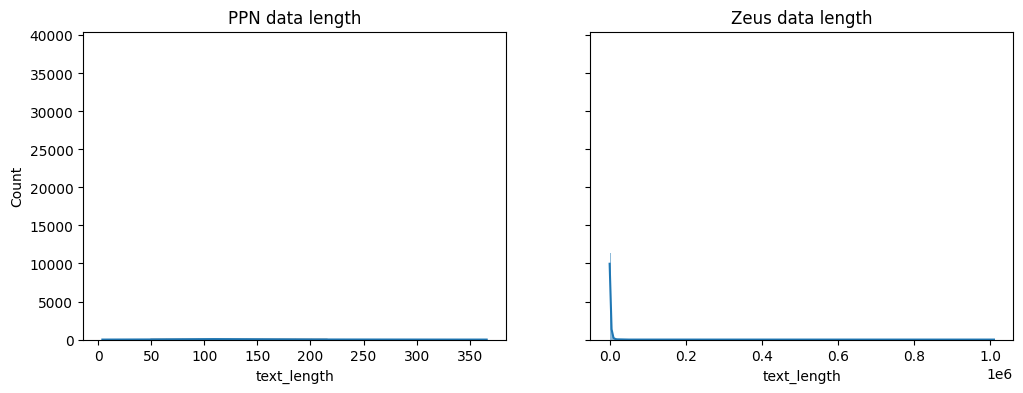

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes = axes.flatten()

sns.histplot(data=df_ppn_ua, x='text_length', kde=True, ax=axes[0])
sns.histplot(data=df_zf_ua, x='text_length', kde=True, ax=axes[1])

axes[0].set_title("PPN data length")
axes[1].set_title("Zeus data length")

plt.show()

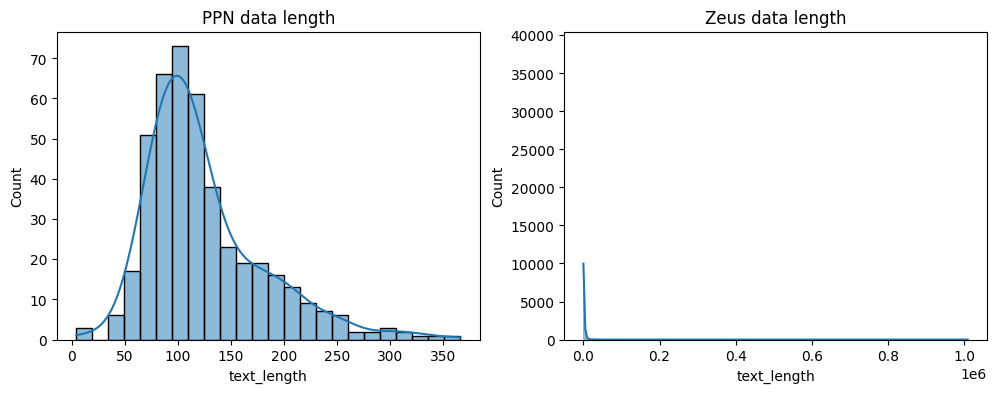

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

axes = axes.flatten()

sns.histplot(data=df_ppn_ua, x='text_length', kde=True, ax=axes[0])
sns.histplot(data=df_zf_ua, x='text_length', kde=True, ax=axes[1])

axes[0].set_title("PPN data length")
axes[1].set_title("Zeus data length")

plt.show()

- as we do not have enough data for ppn dataset - only description, without body article - we cannot use the difference between article length

- for next analysis we have to create another column with same text length distribution

## Sentence length

In [99]:
# Compute sentence lengths
df_ppn_ua['avg_sent_len_desc'] = df_ppn_ua['description'].apply(avg_sentence_length)
df_zf_ua['avg_sent_len_trunc'] = df_zf_ua['truncated_text'].apply(avg_sentence_length)

# Combine into one DataFrame for visualization
df_compare = pd.DataFrame({
    'Sentence Length': list(df_ppn_ua['avg_sent_len_desc']) + list(df_zf_ua['avg_sent_len_trunc']),
    'Dataset': ['description'] * len(df_ppn_ua) + ['truncated_text'] * len(df_zf_ua)
})

/var/folders/c9/28wfm_1x29l6ngxl3s11ym0m0000gn/T/ipykernel_23843/2897117497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ppn_ua['avg_sent_len_desc'] = df_ppn_ua['description'].apply(avg_sentence_length)


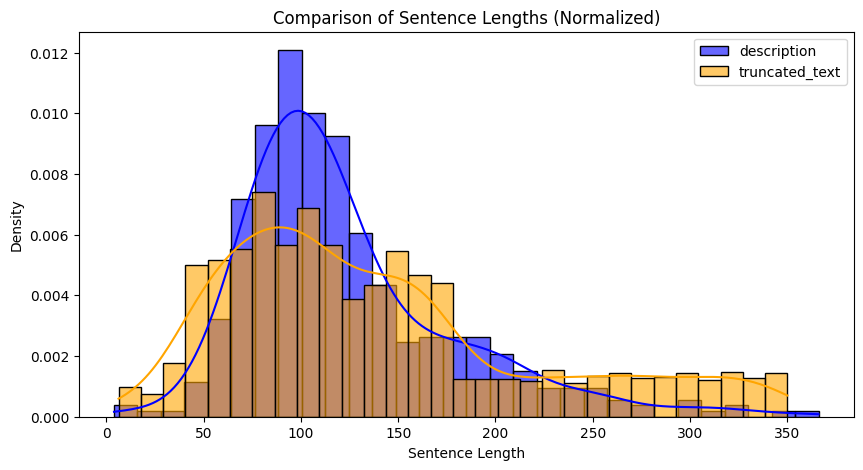

In [100]:
plt.figure(figsize=(10, 5))

# Use `stat="density"` to normalize by dataset size
sns.histplot(df_ppn_ua['avg_sent_len_desc'], label="description", bins=30, kde=True, stat="density", color="blue", alpha=0.6)
sns.histplot(df_zf_ua['avg_sent_len_trunc'], label="truncated_text", bins=30, kde=True, stat="density", color="orange", alpha=0.6)

plt.title("Comparison of Sentence Lengths (Normalized)")
plt.xlabel("Sentence Length")
plt.ylabel("Density")
plt.legend()
plt.show()

- The truncated text distribution is flatter, meaning it includes a wider variety of sentence lengths, while descriptions are more tightly packed around their peak.

- The KDE (density line) for "truncated_text" shows a smoother transition, meaning it has more variance in sentence lengths.

## Punctuation

In [106]:
desc_punc_counts = df_ppn_ua['description'].apply(count_punctuation).sum()
trunc_punc_counts = df_zf_ua['truncated_text'].apply(count_punctuation).sum()

desc_punc_normalized = normalize_counts(desc_punc_counts)
trunc_punc_normalized = normalize_counts(trunc_punc_counts)

In [107]:
# Convert to DataFrame for easier comparison
df_punc_analysis = pd.DataFrame({
    "Punctuation": list(set(desc_punc_normalized.keys()) | set(trunc_punc_normalized.keys())),
    "Description (%)": [desc_punc_normalized.get(p, 0) for p in set(desc_punc_normalized.keys()) | set(trunc_punc_normalized.keys())],
    "Truncated Text (%)": [trunc_punc_normalized.get(p, 0) for p in set(desc_punc_normalized.keys()) | set(trunc_punc_normalized.keys())],
})

# Sort by frequency in "description"
df_punc_analysis = df_punc_analysis.sort_values(by="Description (%)", ascending=False)

In [108]:
print(df_punc_analysis)

   Punctuation  Description (%)  Truncated Text (%)
17           .        47.613883           43.923677
16           ,        36.876356           29.499508
23           :         8.893709            4.073597
11           -         4.989154            7.874612
10           ?         0.650759            0.295298
2            )         0.325380            1.529492
9            (         0.325380            1.635496
4            %         0.216920            0.522450
7            '         0.108460            1.090331
0            *         0.000000            0.022715
24           >         0.000000            0.537594
22           {         0.000000            0.196865
21           $         0.000000            0.075717
20           }         0.000000            0.196865
19           &         0.000000            0.022715
18           !         0.000000            0.719316
13           /         0.000000            0.477020
15           ]         0.000000            0.037859
14          

- Periods (.) dominate both datasets, with 47.6% in "description" and 43.9% in "truncated_text".

- Commas (,) are also widely used but appear less in "truncated_text" (29.5%) compared to "description" (36.8%).

- Colons (:) are more frequent in "description" than in "truncated_text", while hyphens (-) are more frequent in "truncated_text".

- Quotation marks (") appear only in "truncated_text" - can be important input

## Sentiment

In [20]:
sentiment_dict_synt = {}

tree = ET.parse("./xmls/translated_output.xml")  # Update with the actual path
root = tree.getroot()

# Extract words and polarity
for word in root.findall("word"):
    word_form = word.get("form")
    polarity = float(word.get("polarity", 0))  # Default polarity = 0 if not present
    sentiment_dict_synt[word_form] = polarity
    
def calculate_sentiment_synt(text):
    if not isinstance(text, str):
        return 0.0  # Return neutral score for missing values
    words = text.split()  # Tokenize text
    score = sum(sentiment_dict_synt.get(word, 0) for word in words)  # Sum word polarities
    return score

In [18]:
# Load the CSV file (make sure to update the path if needed)
sentiment_df = pd.read_csv("./sentiment_ua.csv", sep=";")

# Convert to dictionary: {word: sentiment_score}
sentiment_dict = dict(zip(sentiment_df["word"], sentiment_df["pos_neg"]))

# Function to calculate sentiment score
def calculate_sentiment(text):
    if not isinstance(text, str):
        return 0.0  # Return neutral score for missing values
    words = text.split()  # Tokenize text
    score = sum(sentiment_dict.get(word, 0) for word in words)  # Sum word polarities
    return score

In [21]:
df_ppn_ua["sentiment_synthetic"] = df_ppn_ua["lemmatized"].apply(calculate_sentiment_synt)
df_zf_ua["sentiment_synthetic"] = df_zf_ua["lemmatized"].apply(calculate_sentiment_synt)
df_ppn_ua["sentiment"] = df_ppn_ua["lemmatized"].apply(calculate_sentiment)
df_zf_ua["sentiment"] = df_zf_ua["lemmatized"].apply(calculate_sentiment)

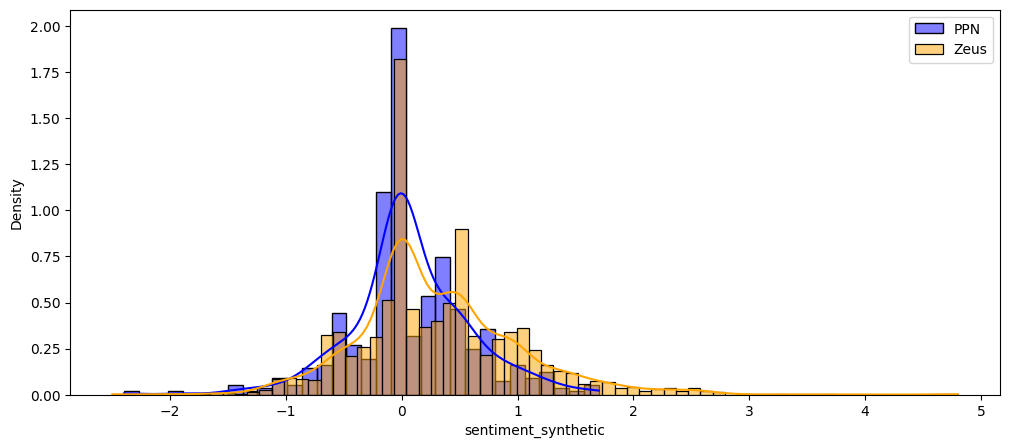

In [23]:
fig, axes = plt.subplots(figsize=(12, 5))

sns.histplot(data=df_ppn_ua, x='sentiment_synthetic', kde=True, stat="density", color='blue', ax=axes, label='PPN')
sns.histplot(data=df_zf_ua, x='sentiment_synthetic',  kde=True, stat="density", color='orange', ax=axes, label='Zeus')

axes.legend()
plt.show()

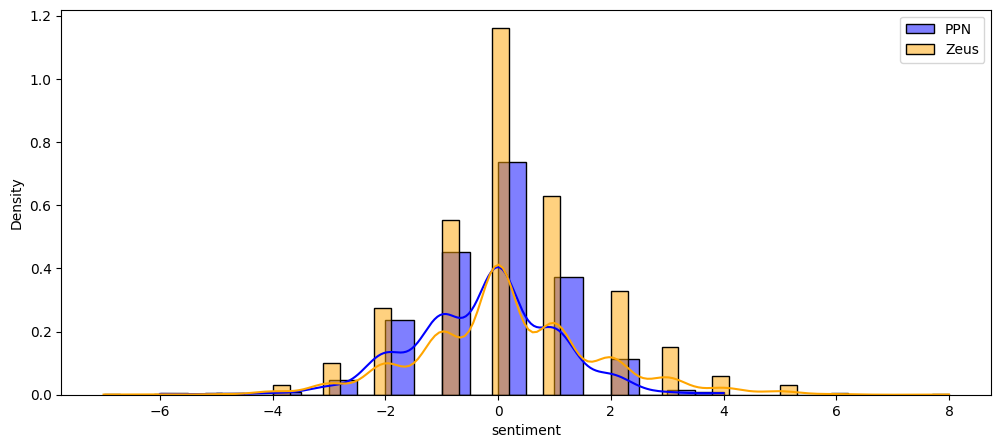

In [24]:
fig, axes = plt.subplots(figsize=(12, 5))

sns.histplot(data=df_ppn_ua, x='sentiment', kde=True, stat="density", color='blue', ax=axes, label='PPN')
sns.histplot(data=df_zf_ua, x='sentiment',  kde=True, stat="density", color='orange', ax=axes, label='Zeus')

axes.legend()
plt.show()

- As we see, the peak in both plots are the same - however "Zeus" data has more tendency to positive, while "PPN" has more negative tendency

## Subjectivness

In [12]:
subj_dict_synt = {}

tree = ET.parse("./xmls/translated_output.xml")  # Update with the actual path
root = tree.getroot()

# Extract words and polarity
for word in root.findall("word"):
    word_form = word.get("form")
    polarity = float(word.get("subjectivity", 0))  # Default polarity = 0 if not present
    subj_dict_synt[word_form] = polarity
    
def calculate_subj_synt(text):
    if not isinstance(text, str):
        return 0.0  # Return neutral score for missing values
    words = text.split()  # Tokenize text
    score = sum(subj_dict_synt.get(word, 0) for word in words)  # Sum word polarities
    return score

In [13]:
df_ppn_ua["subj_synthetic"] = df_ppn_ua["lemmatized"].apply(calculate_subj_synt)
df_zf_ua["subj_synthetic"] = df_zf_ua["lemmatized"].apply(calculate_subj_synt)

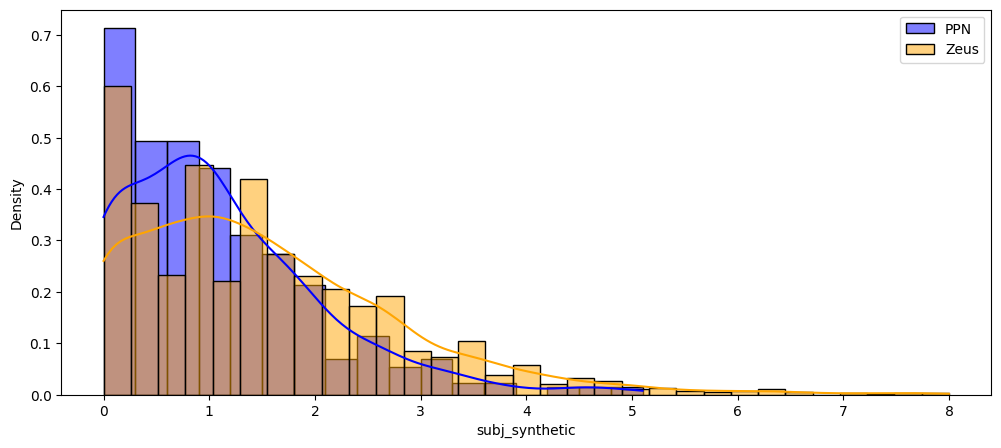

In [25]:
fig, axes = plt.subplots(figsize=(12, 5))

sns.histplot(data=df_ppn_ua, x='subj_synthetic', kde=True, stat="density", color='blue', ax=axes, label='PPN')
sns.histplot(data=df_zf_ua, x='subj_synthetic',  kde=True, stat="density", color='orange', ax=axes, label='Zeus')

axes.legend()
plt.show()

- PPN appears to contain more objective content (e.g., factual reports or neutral statements)

- Zeus contains a broader mix of objective and subjective content, possibly including opinion-based texts

## POS

In [30]:
pos_counts_ppn = get_pos_counts(df_ppn_ua["lemmatized"])
pos_counts_zf = get_pos_counts(df_zf_ua["lemmatized"])

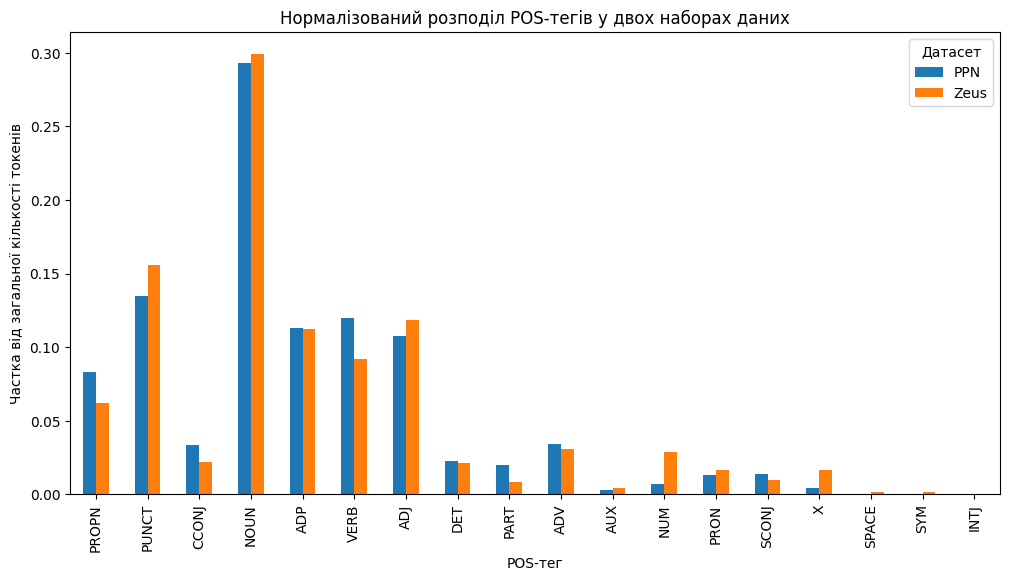

In [31]:
df_pos = pd.DataFrame([pos_counts_ppn, pos_counts_zf], index=["PPN", "Zeus"]).fillna(0)

df_pos.T.plot(kind="bar", figsize=(12, 6))
plt.title("Нормалізований розподіл POS-тегів у двох наборах даних")
plt.xlabel("POS-тег")
plt.ylabel("Частка від загальної кількості токенів")
plt.legend(title="Датасет")
plt.show()

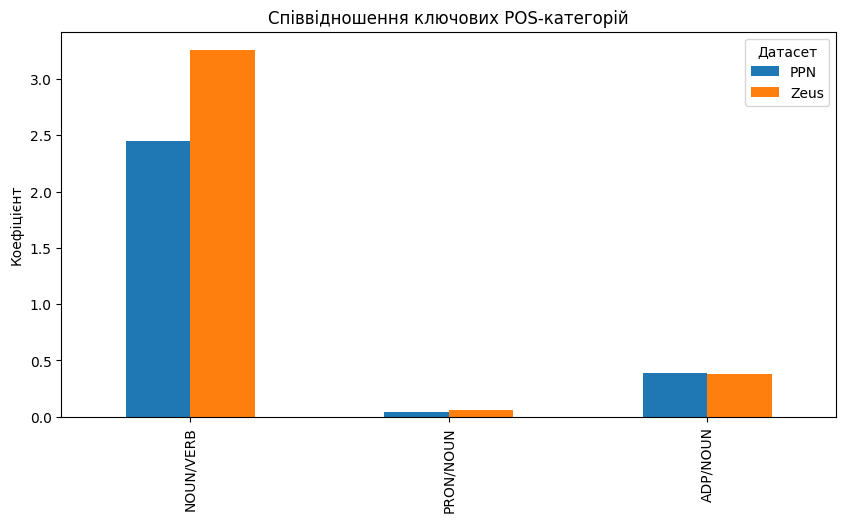

In [32]:
df_pos["NOUN/VERB"] = df_pos["NOUN"] / df_pos["VERB"]
df_pos["PRON/NOUN"] = df_pos["PRON"] / df_pos["NOUN"]
df_pos["ADP/NOUN"] = df_pos["ADP"] / df_pos["NOUN"]

df_pos[["NOUN/VERB", "PRON/NOUN", "ADP/NOUN"]].T.plot(kind="bar", figsize=(10,5))
plt.title("Співвідношення ключових POS-категорій")
plt.ylabel("Коефіцієнт")
plt.legend(title="Датасет")
plt.show()


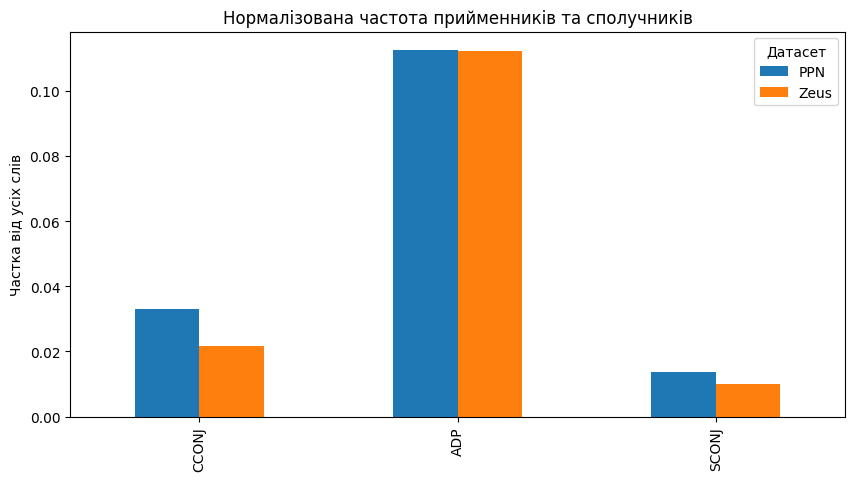

In [34]:
def count_adp_conj(texts):
    counter = Counter()
    total_tokens = 0
    for doc in nlp.pipe(texts, disable=["parser", "ner"]):
        counter.update([token.pos_ for token in doc if token.pos_ in {"ADP", "CCONJ", "SCONJ"}])
        total_tokens += len(doc)
    return {tag: count / total_tokens for tag, count in counter.items()}  # Нормалізуємо

# Підрахунок частоти відносно загальної кількості слів у кожному датасеті
adp_conj_ppn = count_adp_conj(df_ppn_ua["lemmatized"])
adp_conj_zf = count_adp_conj(df_zf_ua["lemmatized"])

# Перетворення у DataFrame
df_adp_conj = pd.DataFrame([adp_conj_ppn, adp_conj_zf], index=["PPN", "Zeus"]).fillna(0)

# Візуалізація
df_adp_conj.T.plot(kind="bar", figsize=(10, 5))
plt.title("Нормалізована частота прийменників та сполучників")
plt.ylabel("Частка від усіх слів")
plt.legend(title="Датасет")
plt.show()

In [72]:
# Function to extract POS tags from a text
def extract_pos_tags(text):
    doc = nlp(text)
    return [token.pos_ for token in doc]

# Function to generate n-grams from a list
def ngrams(tokens, n):
    # Generate n-grams (bigrams, trigrams, etc.)
    it = iter(tokens)
    result = list(zip(*[islice(it, index, None) for index in range(n)]))
    return result

# Process both datasets to extract POS tags
df_ppn_ua['pos_tags'] = df_ppn_ua['lemmatized'].apply(extract_pos_tags)
df_zf_ua['pos_tags'] = df_zf_ua['lemmatized'].apply(extract_pos_tags)

# Generate bigrams and trigrams for each dataset
df_ppn_ua['bigrams'] = df_ppn_ua['pos_tags'].apply(lambda x: ngrams(x, 2))
df_ppn_ua['trigrams'] = df_ppn_ua['pos_tags'].apply(lambda x: ngrams(x, 3))

df_zf_ua['bigrams'] = df_zf_ua['pos_tags'].apply(lambda x: ngrams(x, 2))
df_zf_ua['trigrams'] = df_zf_ua['pos_tags'].apply(lambda x: ngrams(x, 3))

# Flatten the lists to get all bigrams and trigrams in the dataset
all_bigrams_ppn = [bigram for sublist in df_ppn_ua['bigrams'] for bigram in sublist]
all_trigrams_ppn = [trigram for sublist in df_ppn_ua['trigrams'] for trigram in sublist]

all_bigrams_zf = [bigram for sublist in df_zf_ua['bigrams'] for bigram in sublist]
all_trigrams_zf = [trigram for sublist in df_zf_ua['trigrams'] for trigram in sublist]

# Count the occurrences of each bigram and trigram
bigram_counts_ppn = Counter(all_bigrams_ppn)
trigram_counts_ppn = Counter(all_trigrams_ppn)

bigram_counts_zf = Counter(all_bigrams_zf)
trigram_counts_zf = Counter(all_trigrams_zf)

# Compare bigrams and trigrams between the datasets
common_bigrams = bigram_counts_ppn & bigram_counts_zf
common_trigrams = trigram_counts_ppn & trigram_counts_zf

# Display the results
print("Common Bigrams:")
for bigram, count in common_bigrams.items():
    print(f"{bigram}: {count}")

print("\nCommon Trigrams:")
for trigram, count in common_trigrams.items():
    print(f"{trigram}: {count}")

# Optional: Compare most common bigrams and trigrams in each dataset
print("\nMost Common Bigrams in PPN:")
for bigram, count in bigram_counts_ppn.most_common(10):
    print(f"{bigram}: {count}")

print("\nMost Common Bigrams in ZF:")
for bigram, count in bigram_counts_zf.most_common(10):
    print(f"{bigram}: {count}")

print("\nMost Common Trigrams in PPN:")
for trigram, count in trigram_counts_ppn.most_common(10):
    print(f"{trigram}: {count}")

print("\nMost Common Trigrams in ZF:")
for trigram, count in trigram_counts_zf.most_common(10):
    print(f"{trigram}: {count}")

Common Bigrams:
('PROPN', 'PROPN'): 46
('CCONJ', 'NOUN'): 37
('PROPN', 'ADP'): 39
('NOUN', 'ADP'): 237
('NOUN', 'PROPN'): 118
('PROPN', 'PUNCT'): 78
('PROPN', 'VERB'): 96
('ADJ', 'NOUN'): 312
('ADP', 'DET'): 32
('PUNCT', 'PART'): 7
('ADV', 'AUX'): 3
('VERB', 'NOUN'): 137
('ADP', 'NUM'): 13
('NOUN', 'VERB'): 131
('NUM', 'NOUN'): 17
('PART', 'PUNCT'): 3
('ADV', 'VERB'): 41
('VERB', 'PROPN'): 6
('NOUN', 'PUNCT'): 338
('PROPN', 'ADJ'): 21
('PUNCT', 'ADP'): 19
('NOUN', 'ADJ'): 95
('ADV', 'PART'): 11
('VERB', 'PRON'): 12
('NOUN', 'DET'): 14
('CCONJ', 'VERB'): 32
('PUNCT', 'SCONJ'): 49
('DET', 'NOUN'): 49
('ADP', 'ADJ'): 96
('NOUN', 'CCONJ'): 56
('PROPN', 'PRON'): 3
('NOUN', 'NOUN'): 209
('VERB', 'PUNCT'): 48
('PRON', 'NOUN'): 6
('CCONJ', 'ADJ'): 15
('SCONJ', 'VERB'): 25
('NOUN', 'SCONJ'): 2
('PUNCT', 'NOUN'): 68
('PUNCT', 'VERB'): 25
('ADJ', 'CCONJ'): 9
('PROPN', 'CCONJ'): 19
('ADP', 'PRON'): 15
('ADV', 'ADV'): 17
('ADP', 'NOUN'): 232
('ADV', 'PRON'): 6
('VERB', 'ADJ'): 62
('DET', 'ADV'): 1


- The Zeus dataset contains more NOUNs and PUNCT, suggesting a more descriptive or fragmented text style.

- The PPN dataset has more PROPN, indicating a higher focus on named entities.

- The Zeus dataset has higher NOUN/VERB correlation, meaning that text there are more formal-formed

## NER

In [50]:
ner_to_word_ratio_ppn, entity_types_ppn = extract_ner_and_word_count(df_ppn_ua['description'])
ner_to_word_ratio_zf, entity_types_zf = extract_ner_and_word_count(df_zf_ua['truncated_text'])

# Convert to DataFrame for easier manipulation
df_ppn = pd.DataFrame(ner_to_word_ratio_ppn, columns=["NER Count", "Word Count"])
df_zf = pd.DataFrame(ner_to_word_ratio_zf, columns=["NER Count", "Word Count"])

# Calculate the NER to word ratio
df_ppn["NER to Word Ratio"] = df_ppn["NER Count"] / df_ppn["Word Count"]
df_zf["NER to Word Ratio"] = df_zf["NER Count"] / df_zf["Word Count"]

# Calculate the correlation between NER and word count for both datasets
correlation_ppn = df_ppn["NER Count"].corr(df_ppn["Word Count"])
correlation_zf = df_zf["NER Count"].corr(df_zf["Word Count"])

# Print correlation values
print(f"Correlation between NER Count and Word Count in df_ppn_ua: {correlation_ppn:.3f}")
print(f"Correlation between NER Count and Word Count in df_zf_ua: {correlation_zf:.3f}")

Correlation between NER Count and Word Count in df_ppn_ua: 0.489
Correlation between NER Count and Word Count in df_zf_ua: 0.558


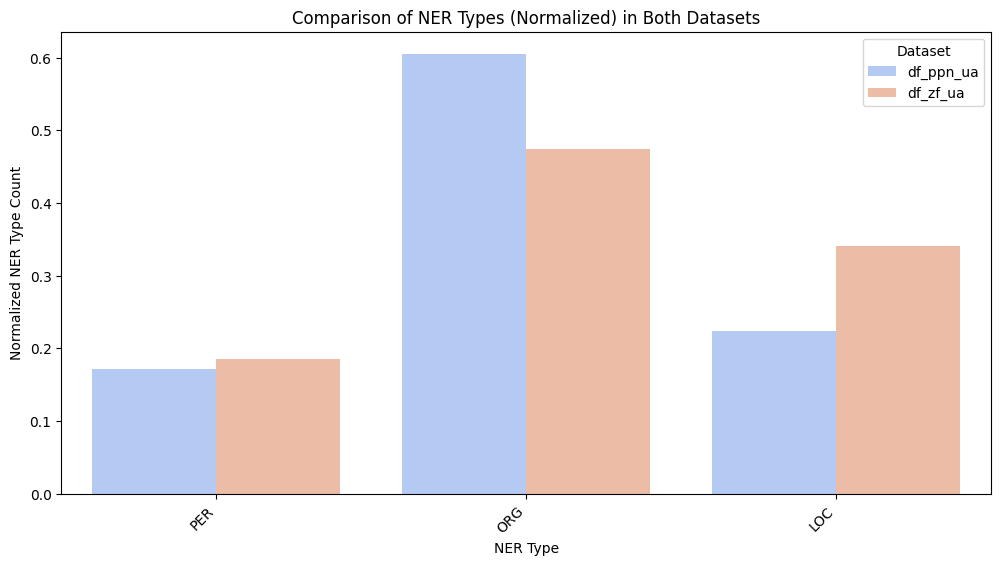

In [51]:
total_ner_ppn = sum(entity_types_ppn.values())
total_ner_zf = sum(entity_types_zf.values())

normalized_entity_types_ppn = {k: v / total_ner_ppn for k, v in entity_types_ppn.items()}
normalized_entity_types_zf = {k: v / total_ner_zf for k, v in entity_types_zf.items()}

# Convert to DataFrame for plotting
df_entity_types = pd.DataFrame({
    "Entity Type": list(set(normalized_entity_types_ppn.keys()).union(set(normalized_entity_types_zf.keys()))),
    "df_ppn_ua": [normalized_entity_types_ppn.get(k, 0) for k in set(normalized_entity_types_ppn.keys()).union(normalized_entity_types_zf.keys())],
    "df_zf_ua": [normalized_entity_types_zf.get(k, 0) for k in set(normalized_entity_types_ppn.keys()).union(normalized_entity_types_zf.keys())]
})

# Melt the DataFrame for easier plotting
df_entity_types_melted = df_entity_types.melt(id_vars=["Entity Type"], var_name="Dataset", value_name="Normalized Count")

# Plot NER types comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=df_entity_types_melted, x="Entity Type", y="Normalized Count", hue="Dataset", palette="coolwarm")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Normalized NER Type Count")
plt.xlabel("NER Type")
plt.title("Comparison of NER Types (Normalized) in Both Datasets")
plt.legend(title="Dataset")
plt.show()

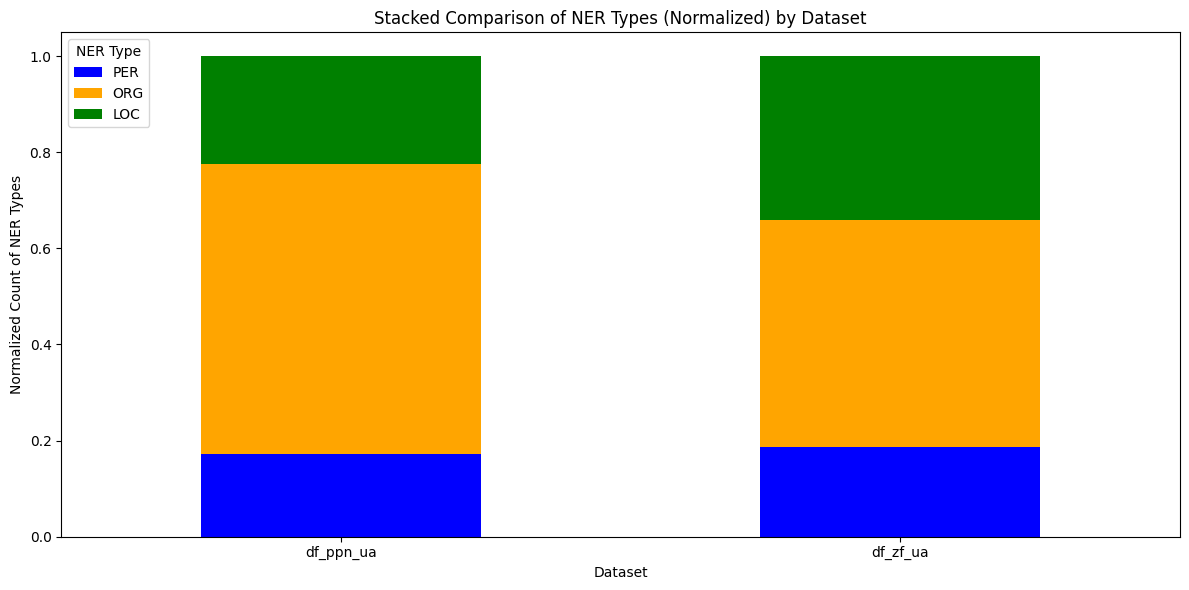

In [54]:
df_entity_types = pd.DataFrame({
    "Entity Type": list(set(normalized_entity_types_ppn.keys()).union(set(normalized_entity_types_zf.keys()))),
    "df_ppn_ua": [normalized_entity_types_ppn.get(k, 0) for k in set(normalized_entity_types_ppn.keys()).union(normalized_entity_types_zf.keys())],
    "df_zf_ua": [normalized_entity_types_zf.get(k, 0) for k in set(normalized_entity_types_ppn.keys()).union(normalized_entity_types_zf.keys())]
})

# Set the "Entity Type" column as the index for easy plotting
df_entity_types.set_index("Entity Type", inplace=True)

# Plot stacked bar chart where each dataset has its own stacked bar for each entity type
ax = df_entity_types.T.plot(kind='bar', stacked=True, figsize=(12, 6), color=["blue", "orange", "green"])

# Customize the plot
plt.title("Stacked Comparison of NER Types (Normalized) by Dataset")
plt.xlabel("Dataset")
plt.ylabel("Normalized Count of NER Types")
plt.xticks(rotation=0)
plt.legend(title="NER Type", loc="upper left")
plt.tight_layout()
plt.show()

- Based on visualisation, the PPN dataset tends to have less NERs in text, but the difference is not large

- We can also see that Zeus dataset tends to mention more Location NERs, when PPN has Organisation tag more used

## langdetect

In [65]:
def get_lang_probabilities(text):
    langs = detect_langs(text)
    lang_dict = {lang.lang: lang.prob for lang in langs}
    return lang_dict

# Apply langdetect to each description
lang_probs = df_ppn_ua['description'].apply(get_lang_probabilities)

# Initialize a dictionary to store the sum of probabilities for each language
lang_sums = {}

# Calculate the sum of probabilities for each language
for lang_dict in lang_probs:
    for lang, prob in lang_dict.items():
        if lang not in lang_sums:
            lang_sums[lang] = 0
        lang_sums[lang] += prob

# Calculate the average for each language
num_rows = len(df_ppn_ua)
lang_averages = {lang: lang_sums[lang] / num_rows for lang in lang_sums}

# Show the result
print(lang_averages)

{'uk': 0.9916505411999372, 'ru': 0.006069487285600341, 'ro': 0.002277891811246536}


In [66]:
for prob in lang_probs:
    print(prob)

{'uk': 0.9999973548763277}
{'uk': 0.9999969991544324}
{'uk': 0.9999977580822761}
{'uk': 0.9999987908150965}
{'uk': 0.999997236635882}
{'uk': 0.9999966049367222}
{'uk': 0.9999992654985506}
{'uk': 0.9999987568593296}
{'uk': 0.9999970612862727}
{'uk': 0.9999975917676067}
{'uk': 0.9999980199885655}
{'uk': 0.9999967951432338}
{'uk': 0.9999972691539181}
{'uk': 0.999999233622908}
{'uk': 0.9999974626964493}
{'uk': 0.9999990006434252}
{'uk': 0.9999987927708547}
{'uk': 0.9999984687784241}
{'uk': 0.9999986050656764}
{'uk': 0.9999985112869082}
{'uk': 0.9999994276165584}
{'uk': 0.9999986021532487}
{'uk': 0.9999966920406974}
{'uk': 0.999998239526911}
{'uk': 0.9999968340315614}
{'uk': 0.9999983549070167}
{'uk': 0.9999986549262626}
{'uk': 0.999997812630888}
{'uk': 0.9999991469669264}
{'uk': 0.9999980795279485}
{'uk': 0.9999985792606645}
{'uk': 0.999997030920834}
{'uk': 0.9999970652241816}
{'uk': 0.9999980141356591}
{'uk': 0.9999963977909876}
{'uk': 0.9999981538029215}
{'uk': 0.9999984921462058}
{'uk':

In [67]:
# Apply langdetect to each description
lang_probs = df_zf_ua['truncated_text'].apply(get_lang_probabilities)

# Initialize a dictionary to store the sum of probabilities for each language
lang_sums = {}

# Calculate the sum of probabilities for each language
for lang_dict in lang_probs:
    for lang, prob in lang_dict.items():
        if lang not in lang_sums:
            lang_sums[lang] = 0
        lang_sums[lang] += prob

# Calculate the average for each language
num_rows = len(df_ppn_ua)
lang_averages = {lang: lang_sums[lang] / num_rows for lang in lang_sums}

# Show the result
print(lang_averages)

{'uk': 5.101191916740203, 'en': 0.01334196199230927, 'ru': 0.016272377217641756, 'it': 0.00032541292558102943, 'bg': 0.0022538894685803774, 'mk': 0.00032541949316749043, 'et': 0.0003254133517865402, 'ca': 0.0003254129920848706}


In [68]:
for prob in lang_probs:
    print(prob)

{'uk': 0.9999985950769463}
{'uk': 0.9999996704702653}
{'uk': 0.9999985312348452}
{'uk': 0.9999978212320783}
{'uk': 0.9999968966126339}
{'uk': 0.9999984410281612}
{'uk': 0.9999978160670684}
{'uk': 0.9999986857319371}
{'uk': 0.9999969359118213}
{'uk': 0.9999987442038063}
{'uk': 0.9999990177687968}
{'uk': 0.9999974462712138}
{'uk': 0.9999975868337577}
{'uk': 0.9999991535836865}
{'uk': 0.9999982121465139}
{'uk': 0.99999663456453}
{'uk': 0.9999976624798433}
{'uk': 0.9999986286284936}
{'uk': 0.9999977218753104}
{'uk': 0.9999958915994989}
{'uk': 0.9999958581602091}
{'uk': 0.999996637828241}
{'uk': 0.9999991173279348}
{'uk': 0.9999990804886716}
{'uk': 0.9999968534293263}
{'uk': 0.999999039099231}
{'uk': 0.9999981599236794}
{'uk': 0.9999966506194191}
{'uk': 0.9999984093833686}
{'uk': 0.9999972206464072}
{'uk': 0.9999967304864684}
{'uk': 0.9999982426918195}
{'uk': 0.9999982444834932}
{'uk': 0.9999986804685237}
{'uk': 0.9999983812832403}
{'uk': 0.9999986683967864}
{'uk': 0.9999977390433178}
{'uk'

- Nothing to get from here

## Results and conclusions

From analysis:

- as we do not have enough data for PPN dataset - only description, without body article - we cannot use the difference between article length

- for next analysis we have to create another column with same text length distribution

- The Zeus text distribution is flatter, meaning it includes a wider variety of sentence lengths, while PPN are more tightly packed around their peak.

- The KDE (density line) for Zeus shows a smoother transition, meaning it has more variance in sentence lengths.

- Periods (.) dominate both datasets, with 47.6% in PPN and 43.9% in Zeus.

- Commas (,) are also widely used but appear less in Zeus (29.5%) compared to PPN (36.8%).

- Colons (:) are more frequent in PPN than in Zeus, while hyphens (-) are more frequent in Zeus.

- Quotation marks (") appear only in Zeus - can be important input

- As we see, the peak in both plots are the same - however Zeus data has more tendency to positive, while PPN has more negative tendency

- PPN appears to contain more objective content (e.g., factual reports or neutral statements)

- Zeus contains a broader mix of objective and subjective content, possibly including opinion-based texts

- The Zeus dataset contains more NOUNs and PUNCT, suggesting a more descriptive or fragmented text style.

- The PPN dataset has more PROPN, indicating a higher focus on named entities.

- The Zeus dataset has higher NOUN/VERB correlation, meaning that text there are more formal-formed

- Based on visualisation, the PPN dataset tends to have less NERs in text, but the difference is not large

- We can also see that Zeus dataset tends to mention more Location NERs, when PPN has Organisation tag more used

What will be added to check:
- column "has_colons"

- column "has_hyphens"

- column "has_quotmarks"

- column "sentiment"

- column "subjectivity"

- column "noun_verb_corr"

- column "location_count"

- column "organisation_count"

# Feature engineering

In [33]:
df_zf_ua = pd.read_csv('./data/uknews-zeus-short.csv')
df_ppn_ua = pd.read_csv('./data/ppn-short.csv')

df = pd.concat([
    pd.DataFrame({'text': df_ppn_ua['description'], 'lemma': df_ppn_ua['lemmatized'], 'propaganda': 1}),
    pd.DataFrame({'text': df_zf_ua['truncated_text'], 'lemma': df_zf_ua['lemmatized'], 'propaganda': 0})
], ignore_index=True)

In [34]:
df['has_colons'] = df['text'].str.contains(':', regex=False).astype(int)
df['has_hyphens'] = df['text'].str.contains('-', regex=False).astype(int)
df['has_quotmarks'] = df['text'].str.contains('"', regex=False).astype(int)

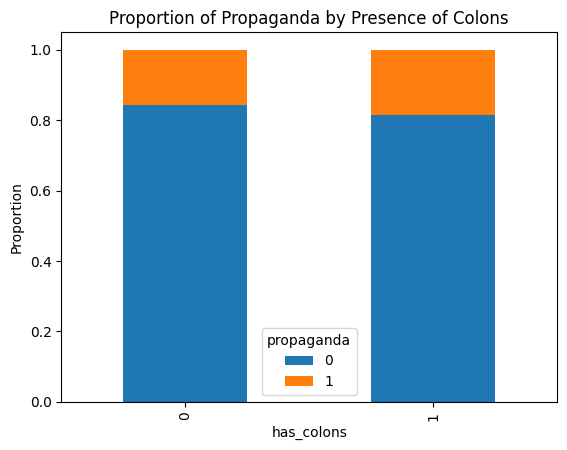

In [35]:
pd.crosstab(df['has_colons'], df['propaganda'], normalize="index").plot(
    kind="bar", stacked=True
)

plt.ylabel("Proportion")
plt.title("Proportion of Propaganda by Presence of Colons")
plt.show()

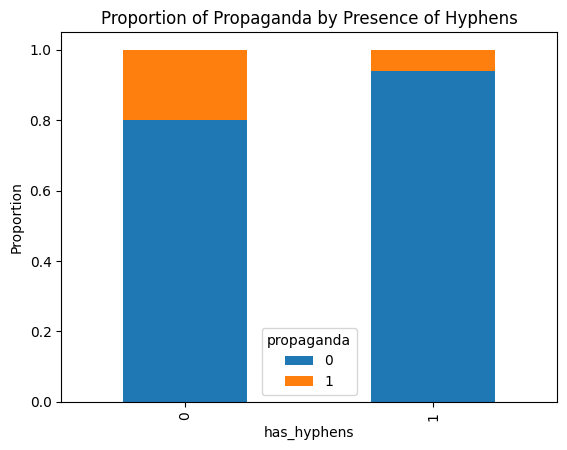

In [36]:
pd.crosstab(df['has_hyphens'], df['propaganda'], normalize="index").plot(
    kind="bar", stacked=True
)

plt.ylabel("Proportion")
plt.title("Proportion of Propaganda by Presence of Hyphens")
plt.show()

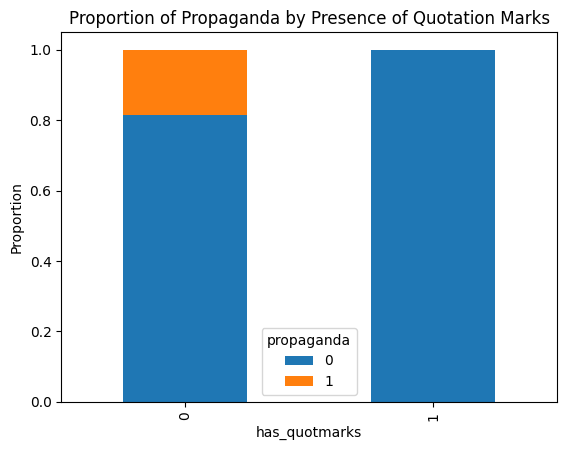

In [37]:
pd.crosstab(df['has_quotmarks'], df['propaganda'], normalize="index").plot(
    kind="bar", stacked=True
)

plt.ylabel("Proportion")
plt.title("Proportion of Propaganda by Presence of Quotation Marks")
plt.show()

In [40]:
df["sentiment"] = df["lemma"].apply(calculate_sentiment)

In [41]:
df["subjectiveness"] = df["lemma"].apply(calculate_subj)

/var/folders/c9/28wfm_1x29l6ngxl3s11ym0m0000gn/T/ipykernel_1029/1302401099.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='propaganda', y='sentiment', palette='bone_r')


<Axes: xlabel='propaganda', ylabel='sentiment'>

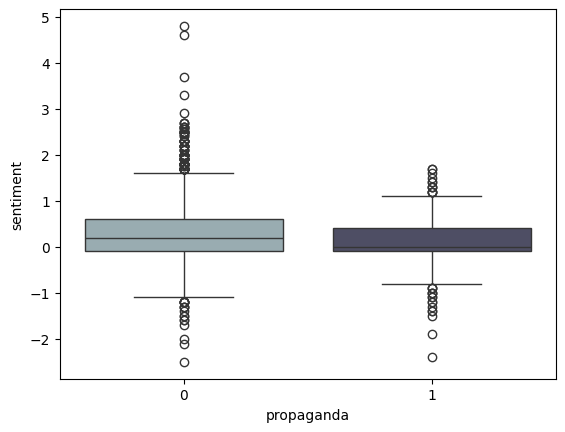

In [46]:
sns.boxplot(data=df, x='propaganda', y='sentiment', palette='bone_r')

/var/folders/c9/28wfm_1x29l6ngxl3s11ym0m0000gn/T/ipykernel_1029/2740922483.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='propaganda', y='subjectiveness', palette='bone_r')


<Axes: xlabel='propaganda', ylabel='subjectiveness'>

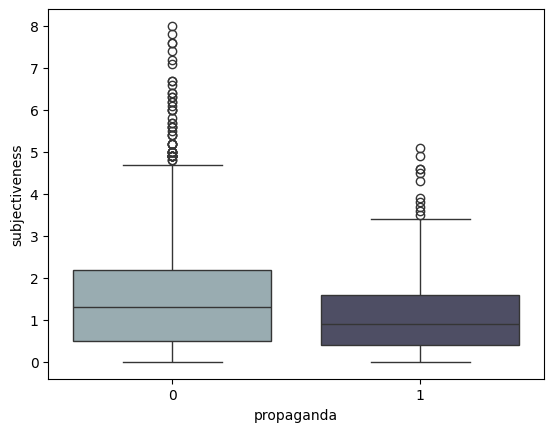

In [47]:
sns.boxplot(data=df, x='propaganda', y='subjectiveness', palette='bone_r')

In [57]:
df['noun_verb_ratio'] = df['lemma'].apply(avg_noun_verb_ratio)

/var/folders/c9/28wfm_1x29l6ngxl3s11ym0m0000gn/T/ipykernel_1029/3423890266.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='propaganda', y='noun_verb_ratio', palette='bone_r')


<Axes: xlabel='propaganda', ylabel='noun_verb_ratio'>

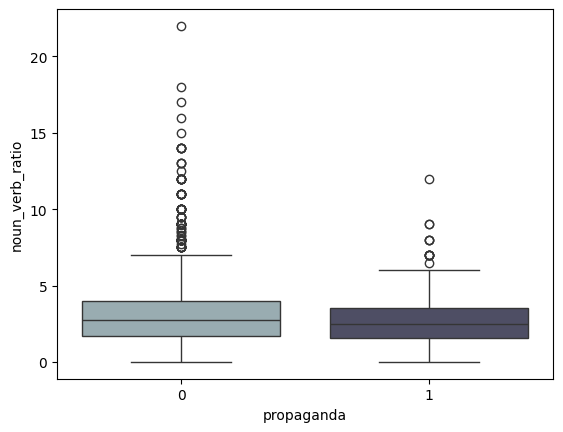

In [58]:
sns.boxplot(data=df, x='propaganda', y='noun_verb_ratio', palette='bone_r')

In [60]:
df[['location_count', 'organization_count']] = df['text'].apply(
    lambda x: pd.Series(count_named_entities(x))
)

/var/folders/c9/28wfm_1x29l6ngxl3s11ym0m0000gn/T/ipykernel_1029/2013099928.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='propaganda', y='location_count', palette='bone_r')


<Axes: xlabel='propaganda', ylabel='location_count'>

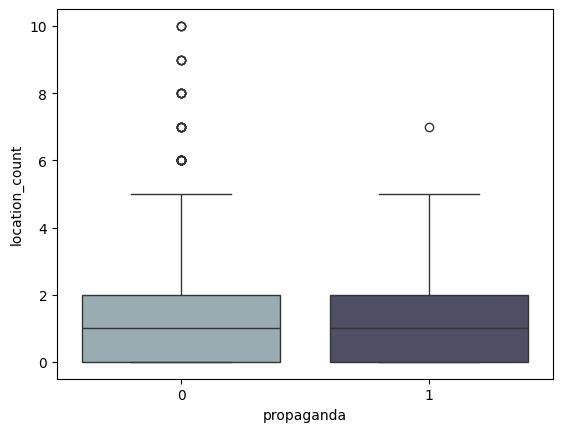

In [61]:
sns.boxplot(data=df, x='propaganda', y='location_count', palette='bone_r')

/var/folders/c9/28wfm_1x29l6ngxl3s11ym0m0000gn/T/ipykernel_1029/554815161.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='propaganda', y='organization_count', palette='bone_r')


<Axes: xlabel='propaganda', ylabel='organization_count'>

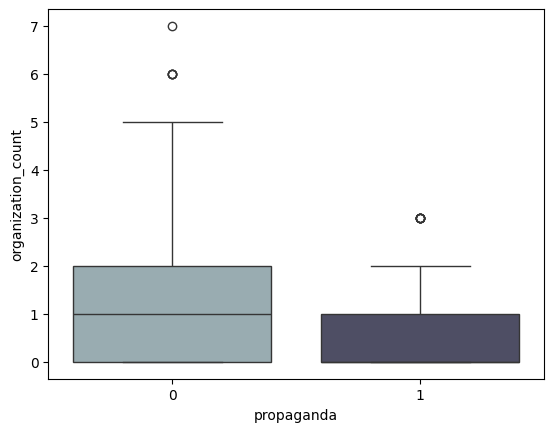

In [62]:
sns.boxplot(data=df, x='propaganda', y='organization_count', palette='bone_r')

In [74]:
vectors = []
for text in tqdm(df['lemma'], desc="Processing Text Vectors"):
    vectors.append(get_text_vector(text, word_vectors))

# Add vectors to DataFrame
df['vector'] = vectors


Processing Text Vectors: 100%|██████████| 2693/2693 [00:15<00:00, 168.96it/s]


# Preprocessing

In [3]:
df = pd.read_csv('./data_vector.csv')

In [216]:
numerics = df.select_dtypes(include=['float64', 'int64']).drop(columns=['propaganda']).columns

In [217]:
df.select_dtypes(include=['float64', 'int64']).drop(columns=['propaganda']).columns

Index(['has_colons', 'has_hyphens', 'has_quotmarks', 'sentiment',
       'subjectiveness', 'noun_verb_ratio', 'location_count',
       'organization_count'],
      dtype='object')

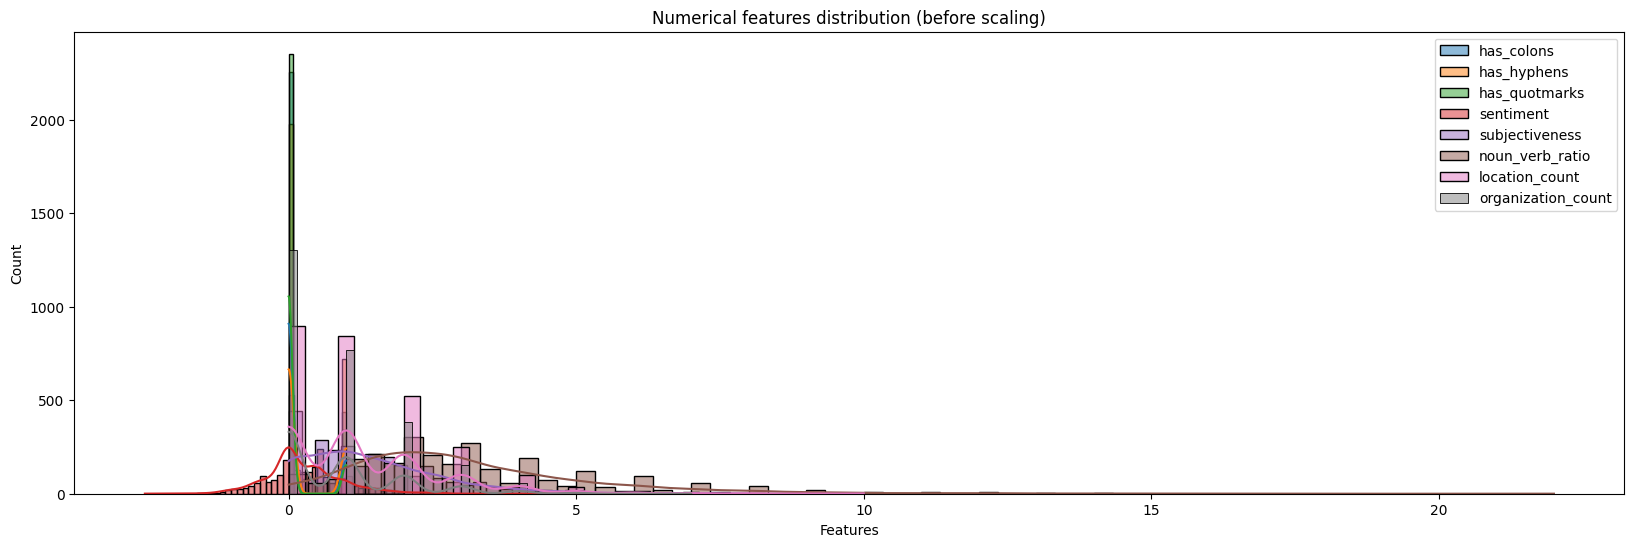

In [124]:
fig, axes = plt.subplots(1, 1, figsize=(20, 6), sharex=True)


for i, column in enumerate(numerics):
    sns.histplot(data=df, x=column, ax=axes, kde=True, label=column)
    
axes.set_title('Numerical features distribution (before scaling)')
axes.set_xlabel('Features')
axes.legend()

plt.show()

In [4]:
scaler = StandardScaler()

numeric_features = ['sentiment', 'subjectiveness', 'noun_verb_ratio', 'location_count', 'organization_count']
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [219]:
import joblib

# Save the scaler to a file
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

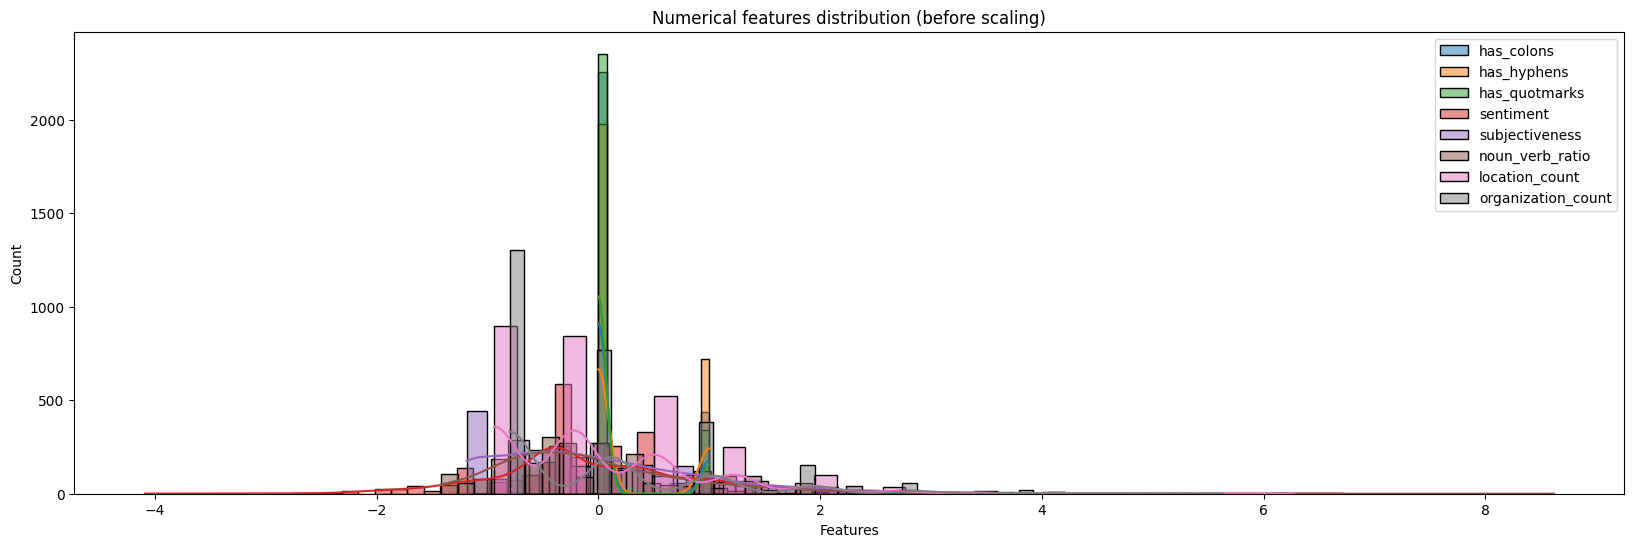

In [126]:
fig, axes = plt.subplots(1, 1, figsize=(20, 6), sharex=True)


for i, column in enumerate(numerics):
    sns.histplot(data=df, x=column, ax=axes, kde=True, label=column)
    
axes.set_title('Numerical features distribution (before scaling)')
axes.set_xlabel('Features')
axes.legend()

plt.show()

In [127]:
df['vector'] = df['vector'].apply(parse_vector)

In [130]:
df.to_csv('data_preprocessed.csv', index=False)

In [ ]:
def preprocess_text(text: str):
    
    # Load your SpaCy model
    nlp = spacy.load('uk_core_news_lg')  # Or the model you're using for lemmatization

    # Load GloVe word vectors
    glove_path = "./news.lowercased.lemmatized.glove.300d.bz2"
    word_vectors = {}

    # Load GloVe vectors into memory
    with bz2.open(glove_path, "rt", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            word_vectors[word] = vector

    # StandardScaler for scaling the features
    scaler = StandardScaler()

    # --- Step 1: Text Preprocessing ---
    
    # 1.1: Tokenize and lemmatize using Spacy
    doc = nlp(text)
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    
    # 1.2: Extract features like punctuation
    has_colons = 1 if ':' in text else 0
    has_hyphens = 1 if '-' in text else 0
    has_quotmarks = 1 if '"' in text else 0
    
    # 1.3: Sentiment & subjectivity (assuming functions are available for sentiment analysis)
    sentiment = calculate_sentiment(text)
    subjectiveness = calculate_subj(text)
    
    # 1.4: Noun-verb ratio calculation (assuming it's already done)
    noun_verb_ratio = avg_noun_verb_ratio(text)
    
    # 1.5: Count location and organization mentions (assuming functions are available)
    location_count, organization_count = count_named_entities(text)
    
    # --- Step 2: Vectorize the text (using GloVe) ---
    vectors = []
    for token in doc:
        word = token.lemma_.lower()
        if word in word_vectors:
            vectors.append(word_vectors[word])
    
    # If there are no valid words found in the GloVe vocabulary, return a zero vector
    if not vectors:
        vector = np.zeros(300)  # 300 is the dimension of GloVe vectors
    else:
        vector = np.mean(vectors, axis=0)
    
    # --- Step 3: Combine all features into a single vector ---
    features = np.concatenate([
        vector,  # GloVe vector (300-dimensional)
        [has_colons, has_hyphens, has_quotmarks],  # Binary features
        scaler.transform([[sentiment]])[0],  # Standardized sentiment
        scaler.transform([[subjectiveness]])[0],  # Standardized subjectiveness
        scaler.transform([[noun_verb_ratio]])[0],  # Standardized noun-verb ratio
        scaler.transform([[location_count]])[0],  # Standardized location count
        scaler.transform([[organization_count]])[0]  # Standardized organization count
    ])
    
    return features

# Classifier

In [133]:
X = np.hstack([
    np.vstack(df['vector'].values),
    df[numerics].values
])
y = df['propaganda'].values

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [142]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [143]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy:.4f}")

XGBoost Accuracy: 0.9239


In [144]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       451
           1       0.89      0.61      0.72        88

    accuracy                           0.92       539
   macro avg       0.91      0.80      0.84       539
weighted avg       0.92      0.92      0.92       539



In [157]:
def construct_model(input_shape: tuple[int, ...], dim_per_layer: list[int], n_classes: int):
    input_x = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Flatten()(input_x)
    for dim in dim_per_layer:
        x = tf.keras.layers.Dense(dim, activation='relu')(x)

    out_x = tf.keras.layers.Dense(n_classes, activation='sigmoid')(x)

    return tf.keras.Model(inputs=input_x, outputs=out_x)

In [207]:
input_shape = (308,)
dim_per_layer = [256, 256, 512]
n_classes = 1

model = construct_model(input_shape, dim_per_layer, n_classes)

In [208]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 308)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 308)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 256)            │        79,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276,993 (1.06 MB)

 Trainable params: 276,993 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [209]:
# Train model
history = model.fit(
    X_train, y_train,
    epochs=40,  # You can increase/decrease
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/40


135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8377 - loss: 0.3573 - val_accuracy: 0.9239 - val_loss: 0.1806
Epoch 2/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9400 - loss: 0.1486 - val_accuracy: 0.9406 - val_loss: 0.1674
Epoch 3/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9596 - loss: 0.0987 - val_accuracy: 0.9406 - val_loss: 0.1577
Epoch 4/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9793 - loss: 0.0677 - val_accuracy: 0.9295 - val_loss: 0.2112
Epoch 5/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9840 - loss: 0.0452 - val_accuracy: 0.9518 - val_loss: 0.1873
Epoch 6/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9823 - loss: 0.0488 - val_accuracy: 0.9443 - val_loss: 0.2213
Epoch 7/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9843 - loss: 0.0413 - val_accuracy: 0.9239 - val_loss: 0.2588
Epoch 8/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9881 - loss: 0.0381 - val_accuracy: 0.9481 - val_

In [210]:
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [211]:
# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.99      0.98       451
           1       0.93      0.81      0.87        88

    accuracy                           0.96       539
   macro avg       0.95      0.90      0.92       539
weighted avg       0.96      0.96      0.96       539



Text(0.5, 1.0, 'Confusion Matrix')

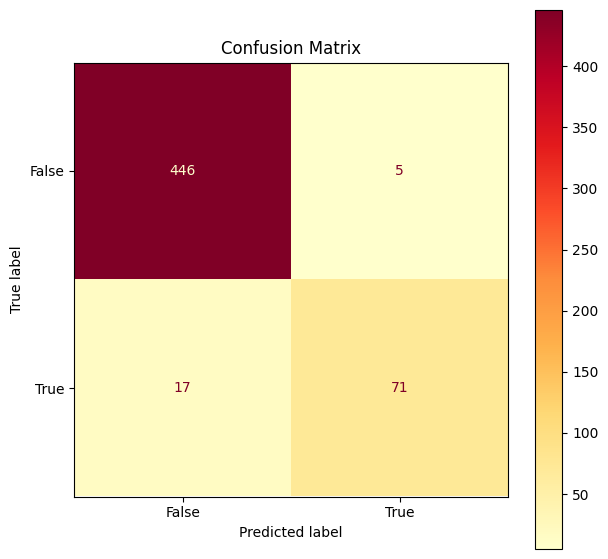

In [212]:
conf_matrix = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(figsize=(7, 7))

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['False', 'True'])
disp.plot(cmap='YlOrRd', ax=axes, values_format='d')
axes.set_title('Confusion Matrix')

In [214]:
model.save("model.keras")

In [ ]:
def preprocess(text):
    df['has_colons'] = df['text'].str.contains(':', regex=False).astype(int)
    df['has_hyphens'] = df['text'].str.contains('-', regex=False).astype(int)
    df['has_quotmarks'] = df['text'].str.contains('"', regex=False).astype(int)

# Multilabel classification using OSINT

In [6]:
df = pd.read_excel('../../data/full_data.xlsx')

In [12]:
morph = pymorphy2.MorphAnalyzer()

def lemmatize_sentence(sentence):
    words = sentence.split()
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    return " ".join(lemmatized_words)

In [7]:
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def embed_sentence(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
df["Sentence"] = df["Sentence"].astype(str)

In [19]:
df["lemmatized_sentence"] = df["Sentence"].apply(lemmatize_sentence)

In [21]:
df["embeddings"] = df["Sentence"].apply(embed_sentence)

In [36]:
X = np.vstack(df["embeddings"].values)
y = df.iloc[:, 1:6].values

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced" )
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [44]:
xgb = XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [49]:
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

In [51]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      0.08      0.12        13
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1

   micro avg       0.33      0.06      0.10        18
   macro avg       0.07      0.02      0.03        18
weighted avg       0.24      0.06      0.09        18
 samples avg       0.00      0.00      0.00        18



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _

In [52]:
print("Random Forest F1:", f1_score(y_test, y_pred_rf, average="macro"))
print("XGBoost F1:", f1_score(y_test, y_pred_xgb, average="macro"))

Random Forest F1: 0.025
XGBoost F1: 0.02857142857142857


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
